In [1]:
import pandas as pd
import numpy as np

from scipy.stats import linregress
from tqdm import tqdm

# READ CRYPTO DATA

In [18]:
def read_crypto_data(ticker):
    df = pd.read_csv(f'../data/validation/{ticker}_1_MIN_INTERVAL.csv', parse_dates=['Time'])
    df.columns = ['TIME', 'CLOSE']

    return df

In [19]:
ticker = 'BTCEUR'
df = read_crypto_data(ticker)
df = df[df['TIME'].dt.minute % 30 == 0]

In [20]:
df.set_index('TIME', inplace=True)

In [21]:
df

,CLOSE
TIME,
2020-01-03 08:00:00,6244.33
2020-01-03 08:30:00,6478.91
2020-01-03 09:00:00,6506.73
2020-01-03 09:30:00,6551.62
2020-01-03 10:00:00,6551.62
...,...
2022-03-31 22:00:00,41400.14
2022-03-31 22:30:00,41408.64
2022-03-31 23:00:00,41386.80


# CALCULATE RSI

In [22]:
def calculate_rsi(df, window):
    returns = df['CLOSE'].pct_change()
    up = returns.clip(lower=0)
    down = np.abs(returns.clip(upper=0))

    ema_up = up.ewm(span=window).mean()
    ema_down = down.ewm(span=window).mean()

    rs = ema_up / ema_down
    rsi = 100 - (100 / (1 + rs))
    df['RSI'] = rsi
    
    return df

# CALCULATE MOVING WEIGHTED AVERAGE

In [23]:
def calculate_ewm(df, window):
    df['EWM'] = df['CLOSE'].ewm(span=window).mean()
    df.dropna(how='any', axis=0, inplace=True)
    
    return df

# IMPLEMENT STRATEGY

In [24]:
def calculate_lags(df):
    for lag in range(0, 12):
        df[f'EWM_LAG_{lag}'] = df['EWM'].shift(lag)
    df.dropna(how='any', axis=0, inplace=True)
    
    return df

In [25]:
def compute_rsi_signal(df, lower_rsi, upper_rsi):
    df['RSI_SIGNAL'] = 'NOTHING'
    df.loc[(df['RSI'] <= lower_rsi), 'RSI_SIGNAL'] = 'BUY'
    df.loc[(df['RSI'] >= upper_rsi), 'RSI_SIGNAL'] = 'SELL'
    
    return df

In [26]:
def compute_ewm_signal(df):
    def mwa_goes_up(row):
        lags = row.filter(regex='LAG').to_numpy()
        x = np.arange(0, len(lags))
        slope = linregress(list(x), list(lags)).slope
        if slope > 0:
            return True
        else:
            return False
    
    df['EWM_GOES_UP_SIGNAL'] = df.apply(mwa_goes_up, axis=1)
    
    return df

In [27]:
def compute_buy_sell_signal(df):
    df['BUY_SELL_SIGNAL'] = 0
    df.loc[(df['RSI_SIGNAL'] == 'BUY') & (df['EWM_GOES_UP_SIGNAL'] == True), 'BUY_SELL_SIGNAL'] = 1
    df.loc[(df['RSI_SIGNAL'] == 'SELL') & (df['EWM_GOES_UP_SIGNAL'] == False), 'BUY_SELL_SIGNAL'] = -1
    
    return df

In [28]:
def remove_multiple_signal_ocurrencens_in_a_row(df):
    current_state = 0
    for i, row in df.iterrows():
        if current_state == 0 and row['BUY_SELL_SIGNAL'] == 1:
            current_state = 1
        elif current_state == 1 and row['BUY_SELL_SIGNAL'] == -1:
            current_state = 0
        else:
            df.loc[i, 'BUY_SELL_SIGNAL'] = 0
    
    return df

In [29]:
%%time

#faltaría otro parametros para el periodo 5 mins, 10 mins, 15 mins, etc
window_ewm = 14
window_rsi = 14
lower_rsi = 40
upper_rsi = 60

df = calculate_ewm(df, window_ewm)
df = calculate_rsi(df, window_rsi)
df = calculate_lags(df)
df = compute_rsi_signal(df, lower_rsi, upper_rsi)
df = compute_ewm_signal(df)
df = compute_buy_sell_signal(df)
df = remove_multiple_signal_ocurrencens_in_a_row(df)
#falta meter el stop loss y take profit con el mínimo y máximo anterior
#falta meter las comisiones de binances para tradear cryptos 0.1% 0.001

CPU times: user 19.6 s, sys: 0 ns, total: 19.6 s
Wall time: 19.6 s


In [30]:
df['RS'] = df['CLOSE'].apply(np.log).diff(1)
df['MY_RS'] = (df['BUY_SELL_SIGNAL'].shift(1) * df['RS'])

<AxesSubplot:title={'center':'Strategy Performance'}, xlabel='TIME'>

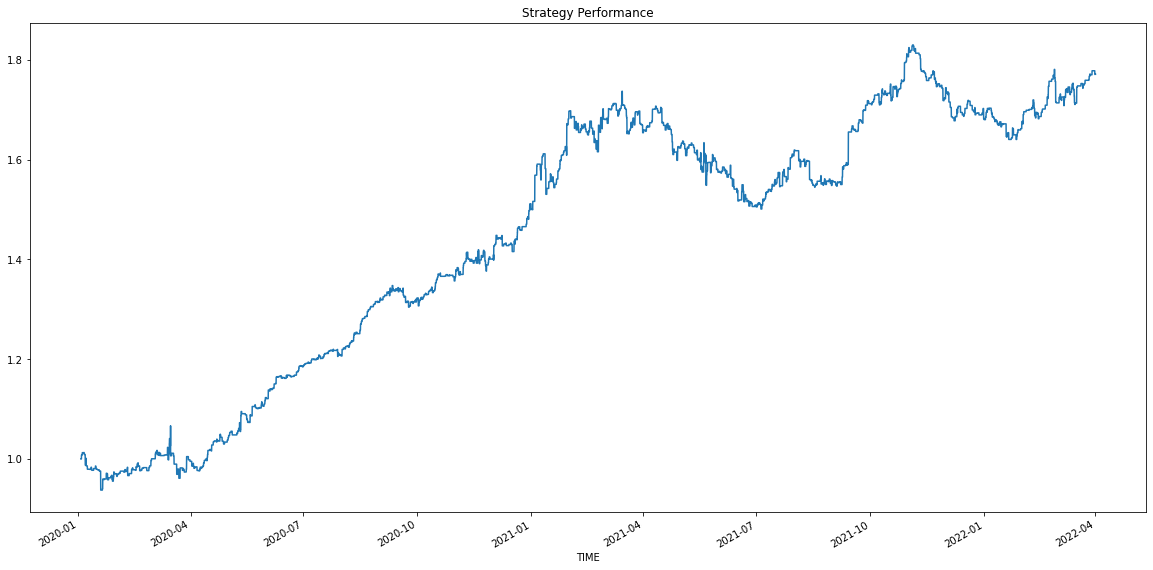

In [31]:
df['MY_RS'].cumsum().apply(np.exp).plot(title='Strategy Performance', figsize=(20,10))

In [83]:
def rsi_ewm_strategy(df, start_investment=1, window_rsi=14, window_mwa=14, lower_rsi=40, upper_rsi=60, stop_loss=-0.1, take_profit=0.1):    
    print('CALCULATING INDICATORS...')
    df = calculate_ewm(df, window_mwa)
    df = calculate_rsi(df, window_rsi)
    df = calculate_lags(df)
    y = df.drop(['RSI', 'EWM'], axis=1)
    #print('INDICATORS CALCULATED')

    #initialize variables
    df['SIGNAL'] = None
    binance_fee = 0.001
    current_state = 'SELL'
    activate_signal = None
    buy_price = None
    accumulated_investment = start_investment
    accumulated_investment_list = list()
    for i in tqdm(range(len(df))):
        row = df.iloc[i,:]
        #check if stop_loss or take_profit conditions are met
        if buy_price is not None:
            pct = ((row['CLOSE'] / buy_price) - 1)
            #print(f'PCT {pct}')
            if pct <= stop_loss:
                #print('ENTRO STOP LOSS')
                df.loc[i, 'SIGNAL'] = 'SELL'
                current_state = 'SELL'
                buy_price = None
                accumulated_investment -= accumulated_investment * binance_fee
                accumulated_investment += accumulated_investment * pct
                accumulated_investment_list.append(accumulated_investment)
                continue
            elif pct >= take_profit:
                #print('ENTRO TAKE PROFIT')
                df.loc[i, 'SIGNAL'] = 'SELL'
                current_state = 'SELL'
                buy_price = None
                accumulated_investment -= accumulated_investment * binance_fee
                accumulated_investment += accumulated_investment * pct
                accumulated_investment_list.append(accumulated_investment)
                continue
        
        #check if buy or sell conditions are met
        y_i = y.iloc[i,:].to_numpy()
        #print(f'ACTIVATE SIGNAL {activate_signal}')
        #print(f'CURRENT STATE {current_state}')
        #print(f'MWA GOES UP {mwa_goes_up(y_i)}')
        if activate_signal == 'BUY' and current_state == 'SELL' and mwa_goes_up(y_i):
            #print('COMPRO')
            df.loc[i, 'SIGNAL'] = 'BUY'
            current_state = 'BUY'
            buy_price = row['CLOSE']
            accumulated_investment -= accumulated_investment * binance_fee
            accumulated_investment_list.append(accumulated_investment)
        elif activate_signal == 'SELL' and current_state == 'BUY' and mwa_goes_up(y_i) == False:
            #print('VENDO')
            df.loc[i, 'SIGNAL'] = 'SELL'
            current_state = 'SELL'
            pct = ((row['CLOSE'] / buy_price) - 1)
            buy_price = None
            accumulated_investment -= accumulated_investment * binance_fee
            accumulated_investment += accumulated_investment * pct
            accumulated_investment_list.append(accumulated_investment)
        else:
            accumulated_investment_list.append(accumulated_investment)
        
        #check if out of rsi boundaries
        if row['RSI'] <= lower_rsi:
            #print('ESTOY POR DEBAJO DEL RSI')
            activate_signal = 'BUY'
        elif row['RSI'] >= upper_rsi:
            #print('ESTOY POR ENCIMA DEL RSI')
            activate_signal = 'SELL'
    
    return df, accumulated_investment, accumulated_investment_list

In [84]:
df, accumulated_investment, accumulated_investment_list = rsi_ewm_strategy(df)

CALCULATING INDICATORS...


,CLOSE,EWM
TIME,,
2020-01-03 08:00:00,6244.33,6244.330000
2020-01-03 08:05:00,6478.91,6369.997857
2020-01-03 08:10:00,6478.91,6411.602666
2020-01-03 08:15:00,6478.91,6432.193878
2020-01-03 08:20:00,6478.91,6444.382043
...,...,...
2022-03-31 23:40:00,41287.90,41326.977655
2022-03-31 23:45:00,40985.43,41281.437968
2022-03-31 23:50:00,40991.91,41242.834239


100%|██████████████████████████████████| 235320/235320 [29:39<00:00, 132.24it/s]


In [85]:
accumulated_investment

0.0004636329002042351

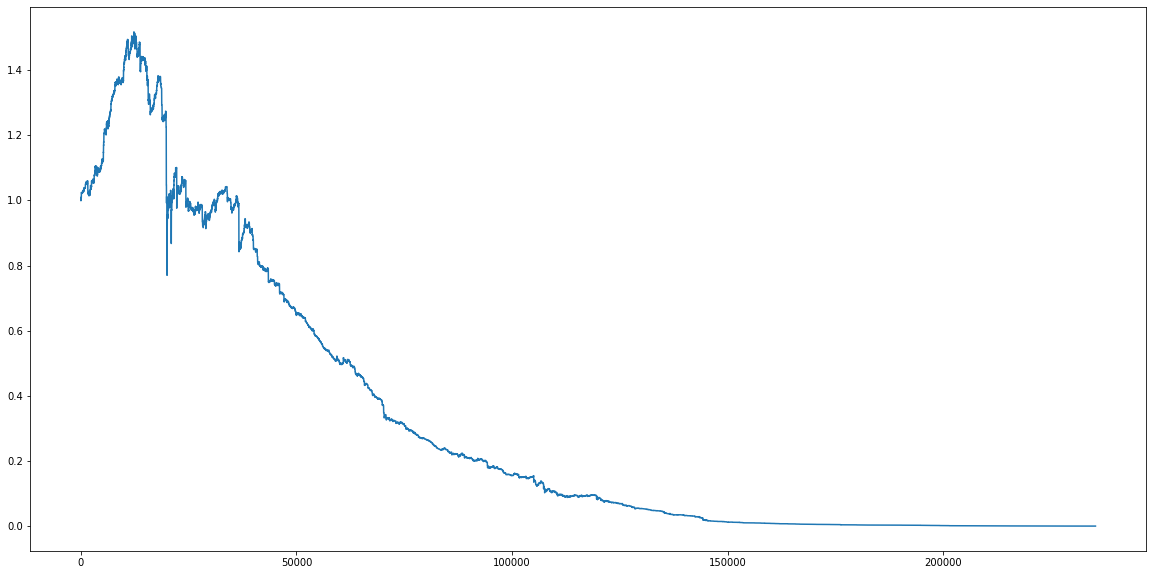

In [86]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,10))
plt.plot(accumulated_investment_list)
plt.show()

In [87]:
df.SIGNAL.value_counts()

BUY     5290
SELL    5289
Name: SIGNAL, dtype: int64